import wfdb
import neurokit2 as nk
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8')


In [1]:
import wfdb
import neurokit2 as nk
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8')


In [2]:
# Set up the directory containing the MIT-BIH Arrhythmia Database files
base_path = '/Users/chkv/Downloads/mit-bih-arrhythmia-database-1.0.0/'

# Define the abnormal symbols from the updated list
abnormal_symbols = {'L', 'R', 'A', 'V', 'F', '[', '!', ']', 'e', 'E', '/'}

def process_record(record_name):
    record_path = base_path + record_name
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')

    # Extract ECG signal
    ecg_signal = record.p_signal[:, 0]

    # Apply NeuroKit preprocessing
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=360)
    r_peaks = nk.ecg_findpeaks(ecg_cleaned, sampling_rate=360)['ECG_R_Peaks']

    # Extract HRV features
    hrv_time = nk.hrv_time(r_peaks, sampling_rate=360, show=False)
   
    # Determine the label based on updated abnormal annotations
    is_abnormal = any(symbol in abnormal_symbols for symbol in annotation.symbol)
    
    return r_peaks, record.fs, is_abnormal, hrv_time, annotation.symbol


In [3]:
# Initialize sets to keep track of normal and abnormal patients
normal_patients = set()
abnormal_patients = set()

# Initialize dictionaries to store HRV features, labels, and annotations for each patient
hrv_features_list = []
labels = []
patient_annotations = {}


In [40]:
# Process each record in the directory
for file in os.listdir(base_path):
    if file.endswith('.dat'):
        record_name = file[:-4]  # Remove the .dat extension to get the record name
        r_peaks, sampling_rate, is_abnormal, hrv_time, annotations = process_record(record_name)
        patient_id = record_name[:3]  # Assuming the first 3 digits correspond to the patient ID

        # Store annotations for the patient
        if patient_id not in patient_annotations:
            patient_annotations[patient_id] = []
        patient_annotations[patient_id].extend(annotations)

        # Determine overall classification for the patient
        abnormal_count = sum(1 for symbol in annotations if symbol in abnormal_symbols)
        total_beats = len(annotations)
        abnormal_ratio = abnormal_count / total_beats

        # Classify patient based on abnormal ratio
        is_patient_abnormal = abnormal_ratio > 0.2
        if is_patient_abnormal:
            abnormal_patients.add(patient_id)
        else:
            normal_patients.add(patient_id)

        # Add HRV features and label to lists
        hrv_features_list.append(hrv_time.to_dict('records')[0])
        labels.append(1 if is_patient_abnormal else 0)

# Convert HRV features to a DataFrame
hrv_df = pd.DataFrame(hrv_features_list)
hrv_df['Label'] = labels

print("Normal Patients:")
for patient in sorted(normal_patients):
    print(patient)
    

print("\nAbnormal Patients:")
for patient in sorted(abnormal_patients):
    print(patient)

Normal Patients:
100
101
103
105
108
112
113
114
115
116
117
121
122
123
201
202
203
205
209
210
213
215
219
220
221
222
228
230
234

Abnormal Patients:
102
104
106
107
109
111
118
119
124
200
207
208
212
213
214
217
223
231
232
233


In [41]:
# Separate features and labels
X = hrv_df.drop(columns=['Label'])
y = hrv_df['Label']
X.head()



,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,556.358139,36.356586,9.517486,29.377050,9.455840,31.186036,9.678506,33.630091,54.905720,54.914189,...,25.000000,0.662164,538.888889,572.222222,9.620722,37.372803,322.222222,1277.777778,5.387043,0.0
1,1302.030223,2047.114966,915.021932,1173.027836,698.463060,1175.353849,403.146705,1284.140946,2377.650520,2378.166592,...,265.277778,0.860982,808.333333,1438.888889,49.567100,72.655123,336.111111,57325.000000,24.315789,0.0
2,657.010678,41.327461,21.497326,34.950788,19.800322,36.318038,19.198930,37.306303,26.135444,26.140180,...,52.777778,1.581280,622.222222,688.888889,5.096469,40.444121,544.444444,983.333333,11.304527,0.0
3,707.747277,160.378980,22.674347,150.569687,16.251550,154.774450,11.379156,157.062929,234.151102,234.197045,...,116.666667,0.684938,613.888889,766.666667,68.078431,86.196078,302.777778,3186.111111,23.611111,0.0
4,687.961198,110.376303,36.548771,55.464669,34.849659,67.222471,34.721711,83.791384,157.667086,157.697158,...,66.666667,0.700059,650.000000,725.000000,3.545559,20.892108,322.222222,3852.777778,8.743333,0.0


In [42]:
# Separate features and labels
X = hrv_df.drop(columns=['Label'])
y = hrv_df['Label']
X.head()



,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,556.358139,36.356586,9.517486,29.377050,9.455840,31.186036,9.678506,33.630091,54.905720,54.914189,...,25.000000,0.662164,538.888889,572.222222,9.620722,37.372803,322.222222,1277.777778,5.387043,0.0
1,1302.030223,2047.114966,915.021932,1173.027836,698.463060,1175.353849,403.146705,1284.140946,2377.650520,2378.166592,...,265.277778,0.860982,808.333333,1438.888889,49.567100,72.655123,336.111111,57325.000000,24.315789,0.0
2,657.010678,41.327461,21.497326,34.950788,19.800322,36.318038,19.198930,37.306303,26.135444,26.140180,...,52.777778,1.581280,622.222222,688.888889,5.096469,40.444121,544.444444,983.333333,11.304527,0.0
3,707.747277,160.378980,22.674347,150.569687,16.251550,154.774450,11.379156,157.062929,234.151102,234.197045,...,116.666667,0.684938,613.888889,766.666667,68.078431,86.196078,302.777778,3186.111111,23.611111,0.0
4,687.961198,110.376303,36.548771,55.464669,34.849659,67.222471,34.721711,83.791384,157.667086,157.697158,...,66.666667,0.700059,650.000000,725.000000,3.545559,20.892108,322.222222,3852.777778,8.743333,0.0


In [43]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:

svm = SVC(C=10, gamma=0.01, kernel='rbf', class_weight='balanced', random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


svm.fit(X_train, y_train)


SVC(C=10, class_weight='balanced', gamma=0.01, random_state=42)

Confusion Matrix:
[[17  6]
 [ 0 16]]
Sensitivity: 1.0
Specificity: 0.7391304347826086

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        23
           1       0.73      1.00      0.84        16

    accuracy                           0.85        39
   macro avg       0.86      0.87      0.85        39
weighted avg       0.89      0.85      0.85        39

ROC AUC: 0.967391304347826


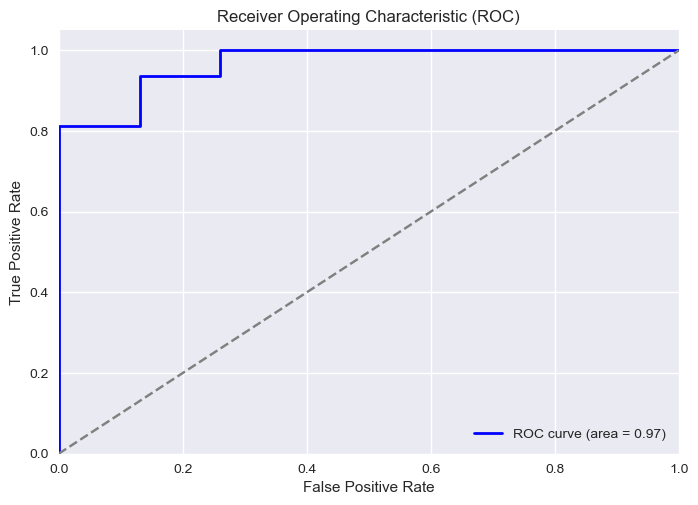

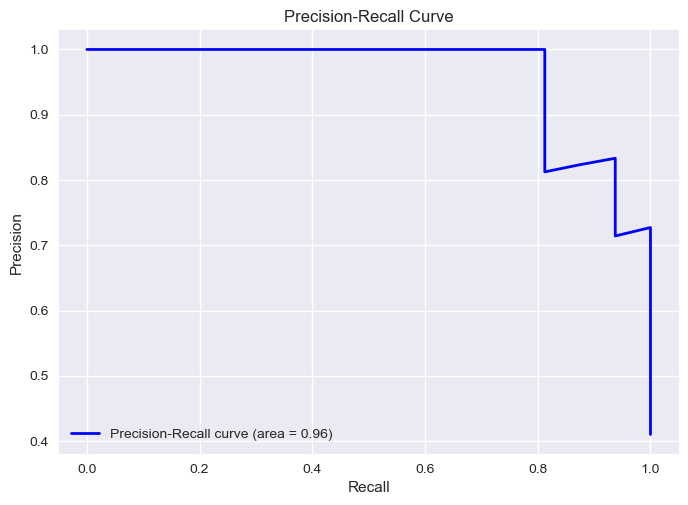

In [45]:
# Make predictions on the test data
y_pred = svm.predict(X_test)
y_score = svm.decision_function(X_test)

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [46]:
# Create a summary DataFrame
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'ROC AUC', 'Precision-Recall AUC'],
    'Score': [
        (tp + tn) / (tp + tn + fp + fn),
        sensitivity,
        specificity,
        roc_auc,
        pr_auc
    ]
})

print("Model Evaluation Summary:")
display(summary)


Model Evaluation Summary:


,Metric,Score
0,Accuracy,0.846154
1,Sensitivity (Recall),1.000000
2,Specificity,0.739130
3,ROC AUC,0.967391
4,Precision-Recall AUC,0.960452


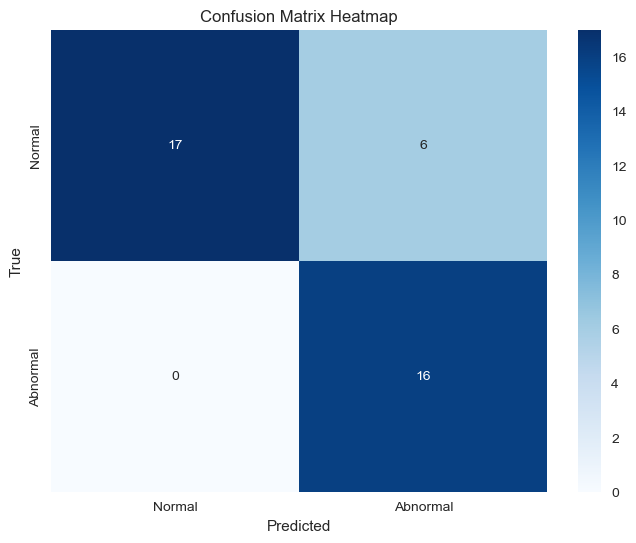

In [47]:
import seaborn as sns

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


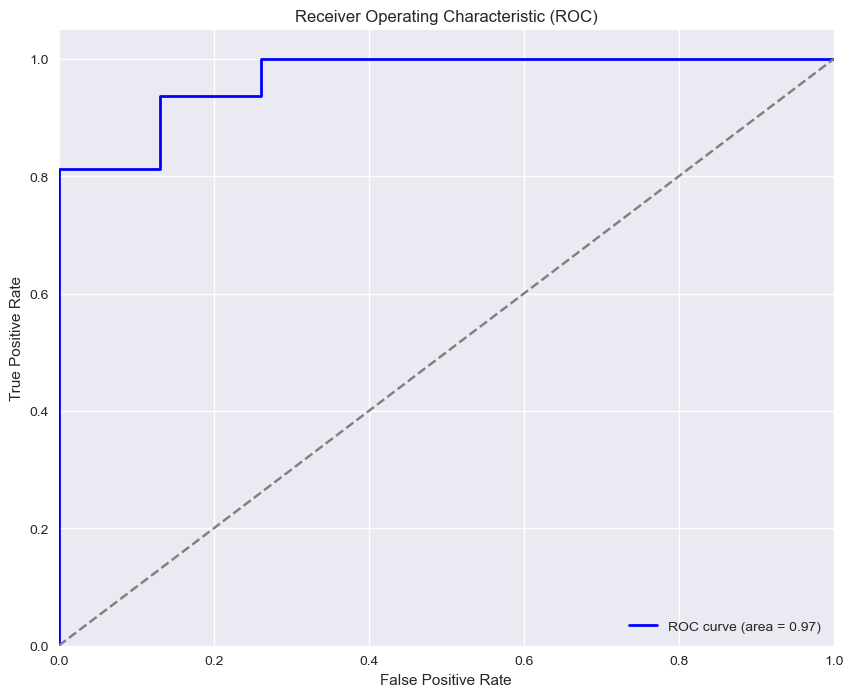

In [48]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [49]:
from IPython.display import display, HTML

# Create a summary DataFrame
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'ROC AUC', 'Precision-Recall AUC'],
    'Score': [
        (tp + tn) / (tp + tn + fp + fn),
        sensitivity,
        specificity,
        roc_auc,
        pr_auc
    ]
})

print("Model Evaluation Summary:")
display(summary)


Model Evaluation Summary:


,Metric,Score
0,Accuracy,0.846154
1,Sensitivity (Recall),1.000000
2,Specificity,0.739130
3,ROC AUC,0.967391
4,Precision-Recall AUC,0.960452


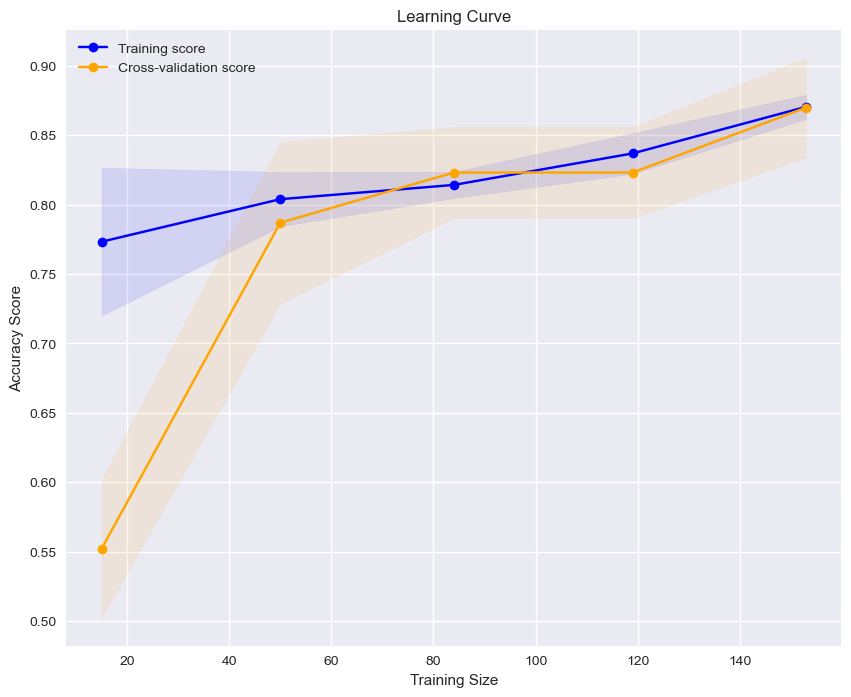

In [50]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    svm, X_scaled, y, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0], cv=5, scoring='accuracy')

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='orange', label='Cross-validation score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='orange')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/var/folders/7q/cxd859554xn5z_vm_xhz961m0000gn/T/ipykernel_24262/3874241902.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])


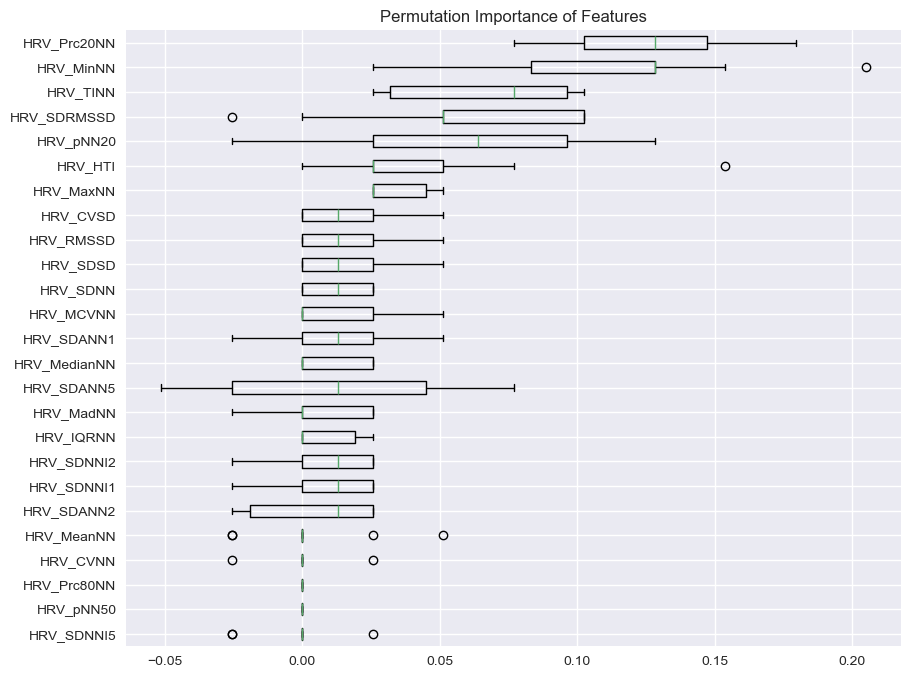

In [51]:
from sklearn.inspection import permutation_importance

result = permutation_importance(svm, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
plt.title('Permutation Importance of Features')
plt.show()
